<a href="https://colab.research.google.com/github/Alejosotog/PruebaAnaliticaLDC__JohnA.SotoGomez/blob/main/PT1/Versi%C3%B3n2_Final_PruebaTecnica_Bancolombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prueba analítica: Segmentación LAFT

#Prueba analítica LDC Ciencia de datos cumplimiento


---
John Alejandro Soto Gómez
--
- Candidato el cargo cientifico de Datos

- Empresa: Bancolombia

- Duración de prueba: 2025-02-28 a 2025-03-03

- Fecha de entrega: 2025-03-01 (Tiempo máx. 11:59am)


---


Base de datos:

Ubicación: Kaggle https://www.kaggle.com/competitions/prueba-analitica-segmentacion-laft

Caracterización del dataset: 5 archivos db_file#.csv un archivo aclaratorio de las columnas "Metadata".

Size: 1.07GB

Dimensión del dataframe: 4885312 filas x 24 columnas.

---
Objetivo:
--
Determinar las capacidades analíticas para desarrollar e implementar modelos. Debe diseñar y construir un modelamiento de segmentación partiendo de la información dada y proponer una solución analítica E2E cumpliendo prácticas de MLOps.


In [4]:
#!pip install category_encoders
#!pip install MiniBatchKMeans

import pandas as pd
import numpy as np
import warnings
import os
import joblib
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from joblib import Parallel, delayed

In [5]:
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# 📂 Obtener la ruta del directorio donde está el notebook
from google.colab import drive
drive.mount('/content/drive')
folder_path = "/content/drive/MyDrive/PruebaTecnica_Bancolombia"



# 📑 Lista de archivos CSV
file_list = ["db_file1.csv", "db_file2.csv", "db_file3.csv", "db_file4.csv", "db_file5.csv"]

# 📥 Cargar datos en lotes para reducir uso de memoria
df_list = [pd.read_csv(os.path.join(folder_path, file), low_memory=False) for file in file_list]
df = pd.concat(df_list, ignore_index=True)

print(f"Datos cargados correctamente con {df.shape[0]} filas y {df.shape[1]} columnas.")

del df_list  # Liberar memoria

# 🔍 Eliminar duplicados
df.drop_duplicates(inplace=True)

# 🛠️ Manejo de valores nulos
df.fillna(df.median(numeric_only=True), inplace=True)

# 🎯 Selección de variables categóricas
cat_vars = ['tipo_cli', 'estado_cli', 'nivel_academico', 'profn', 'ocup', 'tipo_contrato',
            'genero_cli', 'tipo_vivienda', 'pais_nacim', 'origen_fondos', 'operac_moneda_extranjera',
            'ciiu', 'nivel_riesgo_ciiu', 'sociedad_ccial_civ', 'mun_res', 'trn_desc_tip_cta', 'trn_oper', 'trn_efec',
            'trn_canal_serv_efec']

# Verificar si todas las variables categóricas están en el DataFrame
cat_vars = [col for col in cat_vars if col in df.columns]

# 🔹 Reducir categorías con más de 100 valores (para evitar explosión de dimensiones)
max_categorias = 100
for col in cat_vars:
    top_categorias = df[col].value_counts().nlargest(max_categorias).index
    df[col] = np.where(df[col].isin(top_categorias), df[col], "Otros")

# 🔥 Codificación eficiente con Target Encoding
encoder = ce.TargetEncoder(cols=cat_vars)
df[cat_vars] = encoder.fit_transform(df[cat_vars], df['trn_monto'])  # 'trn_monto' como target numérico

# 🔄 Guardar el encoder para futuros usos
joblib.dump(encoder, os.path.join(folder_path, "target_encoder.pkl"))

# 📊 Escalado de variables numéricas
num_vars = ['ing_mes', 'egresos_mes', 'trn_monto', 'score_riesgo_mun']
num_vars = [col for col in num_vars if col in df.columns]  # Verificar existencia

scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

# 📂 Guardar el scaler para futuras predicciones
joblib.dump(scaler, os.path.join(folder_path, "scaler.pkl"))

# 📝 Procesamiento en lotes y guardado en archivos Parquet para evitar saturación de memoria
output_folder = os.path.join(folder_path, "processed_batches")
os.makedirs(output_folder, exist_ok=True)

batch_size = 10000
num_batches = len(df) // batch_size + 1

print(f"Procesando {num_batches} lotes de {batch_size} filas...")

for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    batch.to_parquet(os.path.join(output_folder, f"batch_{i//batch_size}.parquet"))

print("✅ Preprocesamiento finalizado y datos guardados en Parquet.")


Mounted at /content/drive
Datos cargados correctamente con 4885312 filas y 24 columnas.
Procesando 478 lotes de 10000 filas...
✅ Preprocesamiento finalizado y datos guardados en Parquet.


In [6]:
# 🛠️ Muestreo: tomar 500,000 filas aleatorias para mejorar la velocidad
df_sample = df.sample(n=500_000, random_state=42)

# 🔄 Llenar valores nulos con la mediana
df_sample.fillna(df_sample.median(), inplace=True)

# 📏 Estandarizar datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sample)

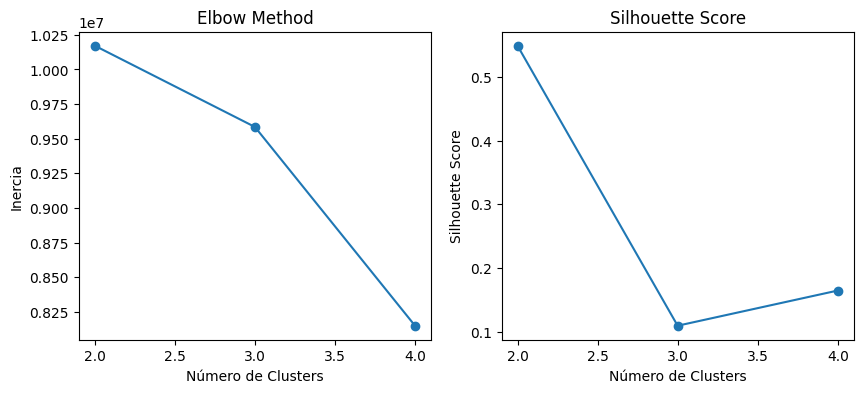

In [7]:
# Rango de clusters a evaluar
K_range = range(2, 5)

def train_kmeans(k, df_scaled):
    """Entrena MiniBatchKMeans y calcula inercia y silhouette score."""
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=40_000,  # Mini-lotes más grandes para mayor velocidad
        n_init=5,           # Reducir inicializaciones
        max_iter=15         # Limitar iteraciones
    )
    labels = kmeans.fit_predict(df_scaled)
    return kmeans.inertia_, silhouette_score(df_scaled, labels)

# Ejecutar en paralelo con múltiples núcleos
results = Parallel(n_jobs=-1)(delayed(train_kmeans)(k, df_scaled) for k in K_range)

# Separar resultados
inertia, silhouette_scores = zip(*results)

# 📉 Gráficos del método del codo y silhouette score
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.show()